# Transcribing handwritten text

**his notebook is divided into 3 parts:<br>**
1. First we transcribe handwritten letters using a cnn to show how simple this task if for cnns<br>
2. Then we progress to taking sentences, and we will build a cnn + Transformer encoder to do this, to show how complex this task is quickly becoming<br>
3. Then we will use TrOCR - a pretrained model to tanscribe our handwritten sentences.<br>



We start with single letters (emnist), then move to a more complicated sentence-level transcription using a cnn plus transformer and iam-line data. The sentence-level task is far more challenging and needs more data, training, and resources.

At the end, we show how large-scale models like trocr, even though pretrained, still require more training and data to approach a near-perfect result.


### Problem statement

In this project I aim to develop a model that accurately transcribes handwritten sentences from image data into machine text, by using a convolutional neural network with a transformer encoder on the iamline dataset.


### Video links

15-minute video: https://drive.google.com/file/d/1rq5cwJ_Ea0cg4aMkymYwhSFapjTucJyf/view?usp=drive_link

3-minute video: https://drive.google.com/file/d/1Sbxl0IkGGcFIMPf3xE4ZvgoYKecn0OxK/view?usp=drive_link


## Environment

I am using python 3.10, tensorflow 2.18.0.



In [ ]:
#!pip uninstall tf-keras # if installed
#!pip install datasets
#!pip install tensorflow==2.18
#!pip install transformers sentencepiece
#!pip install keras-nlp

In [ ]:

!pip install datasets
!pip install keras-nlp==<compatible_version>
!pip install tensorflow==<compatible_version>

#!pip install transformers sentencepiece



In [ ]:
# ensure 3.10
!python --version

Python 3.10.12


In [ ]:
# ensure 2.18
import tensorflow as tf
tf.__version__

'2.17.1'

In [ ]:
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.17.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import IPython.display as disp
from string import ascii_lowercase, digits, punctuation
from tensorflow import keras
from tensorflow.keras import layers, losses
from transformers import VisionEncoderDecoderModel, TrOCRProcessor
import torch
from torch.utils.data import DataLoader
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
import re
from datasets import load_dataset

# First example - character level

This part is focusing on building a model to recognize handwritten letters using a cnn.


### Dataset

I will use the emnist letters dataset. This dataset provides 28x28 pixel grayscale images of handwritten letters. Each image comes with a label representing a letter.

The dataset is publicly available through tensorflow datasets.

### Steps

I will:
1. Load and preprocess the emnist letters data (normalizing and rotating images to correct orientation).
2. Splitting data into training, validation, and test sets.
3. Building a cnn model for classification.
4. Training the model.
5. Evaluating the model.
6. Visualizing the results and predictions.

In [ ]:
dropoutnum = 0.2
epochsnum = 20
batch_size=256

## Data loading and preprocessing


I will now load the emnist letters dataset. It comes with images and labels. I will rotate and flip images to correct their orientation, and normalize pixel values. I also separate data into train, validation, and test sets.

tfds.builder() creates a datasetbuilder object for the emnist dataset. Emnist includes letters instead of just digits.
builder.download_and_prepare() download the dataset and then prepare it.

In [ ]:
builder = tfds.builder('emnist', config='letters')
builder.download_and_prepare()

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/88800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.0Q02IJ_3.1.0/emnist-train.array_record*...:   0%…

Generating test examples...:   0%|          | 0/14800 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/emnist/letters/incomplete.0Q02IJ_3.1.0/emnist-test.array_record*...:   0%|…

Dataset emnist downloaded and prepared to /root/tensorflow_datasets/emnist/letters/3.1.0. Subsequent calls will reuse this data.


In [ ]:
# returns pipelines to access the data
srctrain = builder.as_data_source(split='train')
srctest = builder.as_data_source(split='test')

In [ ]:
# Get the number of training examples from the builder info
trainex = builder.info.splits['train'].num_examples
tcount = int(0.8 * trainex)
vcount = int(0.2 * trainex)

In [ ]:
trainex

88800

I'll make two generator functions. Each  loops over source (source_train or and for each example ex, extracts ex['image'] and ex['label'].
The yield image, label line makes the function a generator that will produce image, label  one by one.

At this point, it is a python generator, not tensorFlow datasets.

In [ ]:
# Each image is a 28x28 grayscale image, and label is an integer
# for the letter class.
def gen_train():
    for ex in srctrain:
        image = ex['image']
        label = ex['label']
        yield (image, label)

def gen_test():
    for ex in srctest:
        image = ex['image']
        label = ex['label']
        yield (image, label)

In [ ]:
# converts generators into tf.data.Dataset
ds_train_full = tf.data.Dataset.from_generator(
    gen_train,
    output_signature=(tf.TensorSpec(shape=(28,28,1), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.int64))
)

ds_test = tf.data.Dataset.from_generator(
    gen_test,
    output_signature=(tf.TensorSpec(shape=(28,28,1), dtype=tf.uint8), tf.TensorSpec(shape=(), dtype=tf.int64))
)

In [ ]:
print(ds_train_full.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


In [ ]:
# Splitting ds_train_full into ds_train and ds_val before preprocessing
ds_train = ds_train_full.take(tcount)
ds_val = ds_train_full.skip(tcount).take(vcount)

In [ ]:
print(ds_train.element_spec)

(TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))


### Visualize before preprocessing
Let's visualize some samples from the training set to understand what the images look like, before we fix rotation

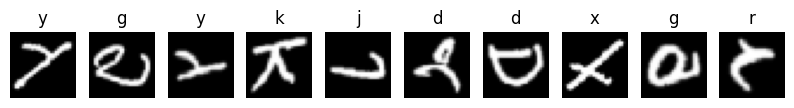

In [ ]:
plt.figure(figsize=(10, 3))

samp = list(ds_train.take(10))# Taking 10 separate image, label pairs

for idx, (i, l) in enumerate(samp):
    plt.subplot(1,10,idx+1)
    plt.imshow(i.numpy().squeeze(), cmap='gray')
    plt.title(chr(l.numpy()+96))
    plt.axis('off')
plt.show()


The letters are rotated or flipped by default. At first, I trained the model with the data like this, as in a way you can think of this as a data augmentation. However, they are so aggressively flipped and rotated, that even for me it is hard to accurately see what character it is. This is unnatural, and we do not need a model that can read the characters augmented that aggressively. So let's correct this, and see if we get good accuracy without.

# Preprocess

# Preprocess
Rotating, flipping, and normalizing the images. Adjusting labels from 1-26 to 0-25.


In [ ]:
def prep(image, label):
    # Rotating the image 3 times 90 degrees
    image = tf.image.rot90(image, k=3)
    # Flipping left to right
    image = tf.image.flip_left_right(image)
    # Normalizing to 0,1
    image = tf.cast(image, tf.float32) / 255.0
    # Labels go from 1-26, shifting to 0-25
    label = label - 1
    return image, label


Then I will apply the preprocess function to each image, label.
num_parallel_calls=tf.data.AUTOTUNE allows tf to decide best level of parallelism when preprocessing

In [ ]:
trainset = ds_train.map(prep, num_parallel_calls=tf.data.AUTOTUNE)
valset = ds_val.map(prep, num_parallel_calls=tf.data.AUTOTUNE)
testset = ds_test.map(prep, num_parallel_calls=tf.data.AUTOTUNE)

# Creating Batches
We shuffle and batch the training data, and just batch the validation and test data.


In [ ]:
# shuffling so the model will not know the order
trainset = trainset.repeat().shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
valset = valset.repeat().batch(batch_size).prefetch(tf.data.AUTOTUNE)
testset = testset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

## Visualizing

Let's look at a few training images and their labels. This helps confirm that preprocessing worked and that letters looks as expected.

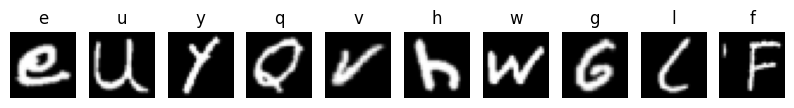

In [ ]:
samp = trainset.take(10) # take on batch, but only viz 10

plt.figure(figsize=(10, 3))

for idx, (i, l) in enumerate(samp):
    plt.subplot(1,10,idx+1)
    plt.imshow(i.numpy()[idx].squeeze(), cmap='gray')
    plt.title(chr(l.numpy()[idx]+97))
    plt.axis('off')
plt.show()



Yep,this looks good now.

## Model (cnn)
We build a cnn with multiple convolutional layers, batchnorm, pooling, and dropout to classify letters. The output is a softmax over 26 letters.


### about CNNs

Convolutional layers learn filters (also called kernels) that finds patterns in an image. Early layers often will learn very simple features like edges or corners. Deeper layers will combine those into more complex patterns.

Since letters are basically strokes and shapes, cnn filters are good at detecting them. When I stack multiple convolutional layers, the network learns a hierarchy of features: first more simple edges in the first layers to more letter-like shapes in the deeper layers.


### about the model parameters


I went steadily up in filter size from **64 -> 128 -> 256 filters**.

Starting with **64 filters** in the first layer means model learn a small number of simple features.

Then increasing the number of filters to **128, then 256** in deeper layers gives the model bigger capacity to find complex patterns.

I used **3x3 kernel**.  This is a pretty standard kernel that is used in for example VGG, Resnet blocks, etc. Its big enough to find patterns but small enough to not overfit too mycg.

When I use several 3x3 layers on top of each other, the model gets a broader view - similar to what it would have if we used big filters, but now it can see both details and a broader view.

I used a standard **relu activation**, which is efficient and also helps against vanishing gradients.

After each convolutional layer, I used  **Batchnormalization**. This normalizes the activations before the next layer, so training is much faster.

**MaxPooling2D layers** - size 2,2 will make the feature maps smaller which makes the model more computational efficient. It also allows the model to learn more abstact and higher level of features, while the data becomes lower in dimension at the same time.

The fully connected network in the end, lets the model combine all the feature it has found, and it will use this to make a decision around what was in the picture.  

**dropout_rate=0.2** reduce overfitting by randomly setting some neurons to zero during training. This means the model cannot memorize the data as well, and the result will be that the model generalizes better.


In [ ]:
num_classes = 26
dropout_rate = 0.2

In [ ]:


modelcnn = tf.keras.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2)),

    tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(dropout_rate),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
optim = tf.keras.optimizers.Adam(learning_rate=1e-3)

In [ ]:
modelcnn.compile(
    optimizer=optim,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
modelcnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)                    │ (None, 26, 26, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 26, 26, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 13, 13, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 11, 11, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 11, 11, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 5, 5, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 3, 3, 256)           │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 3, 3, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 26)                  │           6,682 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 969,242 (3.70 MB)

 Trainable params: 967,834 (3.69 MB)

 Non-trainable params: 1,408 (5.50 KB)

## Training the model

I train for up to 20 epochs, but i use early stopping to stop if the model stops improving. I also use reduce_lr_on_plateau,

Earlystopping monitors validation loss and stops the training when no improvement after 5 steps. This is to now waste time, to avvoid overfitting, and to revert back to the best model if we train too long.

Reducelronplateau helps because it lowers the learning rate when the models performance plateaus, so we dont get stuck in local minima and we can go fast when it is all downhill gradients.

In [ ]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)

decay_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=3,
    verbose=1
)



In [ ]:
# since it is a generator, we cannot let the model find steps_per_epoch itself
# as the number of examples are not known
training_steps = tcount // batch_size
val_steps = vcount // batch_size

In [ ]:
hist = modelcnn.fit(
    trainset,
    validation_data=valset,
    epochs=200,
    callbacks=[early_stop, decay_lr],
    steps_per_epoch=training_steps,
    validation_steps=val_steps
)

Epoch 1/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 136s 433ms/step - accuracy: 0.7899 - loss: 0.7293 - val_accuracy: 0.0451 - val_loss: 9.3772 - learning_rate: 0.0010
Epoch 2/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 81s 293ms/step - accuracy: 0.9276 - loss: 0.2145 - val_accuracy: 0.8374 - val_loss: 0.5009 - learning_rate: 0.0010
Epoch 3/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 81s 293ms/step - accuracy: 0.9411 - loss: 0.1679 - val_accuracy: 0.9317 - val_loss: 0.2031 - learning_rate: 0.0010
Epoch 4/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 81s 295ms/step - accuracy: 0.9506 - loss: 0.1356 - val_accuracy: 0.9350 - val_loss: 0.2031 - learning_rate: 0.0010
Epoch 5/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 82s 296ms/step - accuracy: 0.9557 - loss: 0.1175 - val_accuracy: 0.9312 - val_loss: 0.2114 - learning_rate: 0.0010
Epoch 6/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 83s 299ms/step - accuracy: 0.9624 - loss: 0.0976 - val_accuracy: 0.9380 - val_loss: 0.2078 - learning_rate: 0.0010
Epoch 7/200
277/277 ━━━━━━━━━━━━━━━━━━━━ 113s 410ms/step - accu

## Evaluation

Let's now check how well the model does on completely unseen data, to see true performance. If it still scores high, it means it generalizes well and didn't just memorize the training data.

In [ ]:
test_loss, test_acc = modelcnn.evaluate(testset)
print(f"Test accuracy: {test_acc*100:.2f}%")

58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9308 - loss: 0.2549
Test accuracy: 93.16%


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


## Visualization

I plot the training and validation accuracy to see if the model improved or if it overfitted. By looking at these curves, you can understand if more data or more epochs would help, or if the model might have reached a good point.

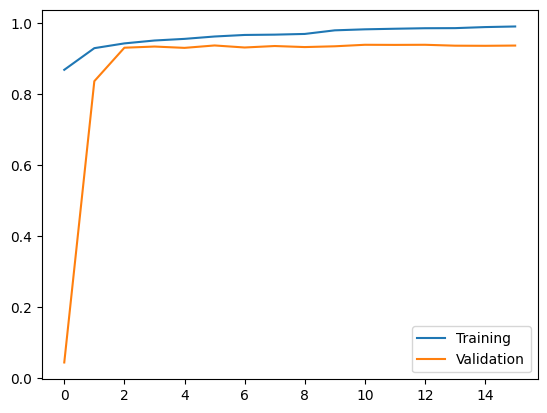

In [ ]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs_range = range(len(acc))

plt.plot(epochs_range, acc, label='Training')
plt.plot(epochs_range, val_acc, label='Validation')

plt.legend()


## Sample predictions
Let's see some predictions on test images to get a feel for how well it works.


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  


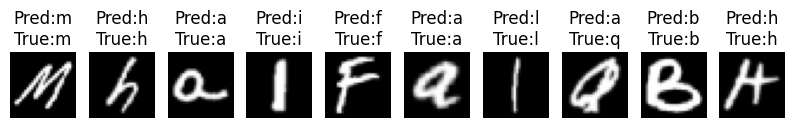

In [ ]:
for images, labels in testset.take(1):

    preds = modelcnn.predict(images)
    pred_classes = np.argmax(preds, axis=1)
    plt.figure(figsize=(10,3))
    for i in range(10):
        plt.subplot(1,10,i+1)

        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f"Pred:{chr(pred_classes[i]+97)}\nTrue:{chr(labels[i].numpy()+97)}")
        plt.axis('off')
    plt.show()
    break

## Conclusion
The cnn works well for single letters, but full sentence transcription is harder. With further refinement, such as adding data augmentation or using more advanced architectures, i could push accuracy even higher.

_____________________________________________________



# Cnn + transformer model to transcribe sentences




Now I try a more advanced setup: using a cnn as a feature extractor and a transformer for sequence modeling. Ctc loss aligns predictions with inputs.

We only show a few training steps because fully training this model to very low loss would take a lot of time and computational power.

Even huge pretrained models like trocr, starting from a low loss, still need fine-tuning and data.

What we are no trying to do is to feed an image of a handwritten sentence into a CNN that will extract visual features from the text. I like to think of it as the CNN is an encoder, encoding our picture into a latent dimension and then we will use Transformer to decode it (although we are technically using the Transformer encoder arcitecture, since it is not supposed to be an autoregressive model, so we cannot use decoder).

The CNN looks for patterns in the strokes, curves, and spacing of letters, and transforms the pixels into a abstract embedding. This should captre both letters and where in the picture they are. When we have that embedding, the transformer on top is like a decoder. It will take the embedding and try to translate it into a sequence of characters that form meaningful words and sentences by using atttention.

However, this is much harder than classifying single letters. When having entire sentences, the handwriting style is much more important. Letters blurs, spacing can be bad.

To get a good model, we would need a huge dataset, more computational resources and a deep CNN encoder and transformer decoder.

## Introduction
Extract features with cnn, then feed to a transformer. We use ctc loss for alignment.


Ctc loss, or connectionist temporal classification loss, will let our model learn to recognize sequences without needing us to match each input step to a output step in advance.

I needed to use this type of loss, so I did not have to go through each picture and manually find out where in the picture each letter was. By letting the model to figure out how to put the inputs with the outputs, ctc loss can then handle different length and different spacing etc.


But: training with ctc loss can be very difficult and you need much more data and tuning. Even with a lot of work, getting the ctc loss very low was just too hard, as you will see.

### Loading iam-line dataset
This dataset has line-level handwritten text images. The complexity is higher.


## Data

In [ ]:
dataset_iam = load_dataset("Teklia/iam-line")
print(dataset_iam)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 6482
    })
    validation: Dataset({
        features: ['image', 'text'],
        num_rows: 976
    })
    test: Dataset({
        features: ['image', 'text'],
        num_rows: 2915
    })
})


Visualizing a few samples.

Sample 0 Text: put down a resolution on the subject


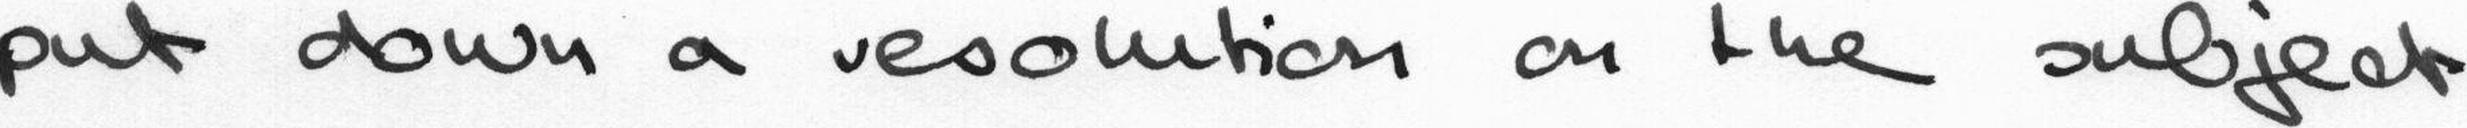

Sample 1 Text: and he is to be backed by Mr. Will


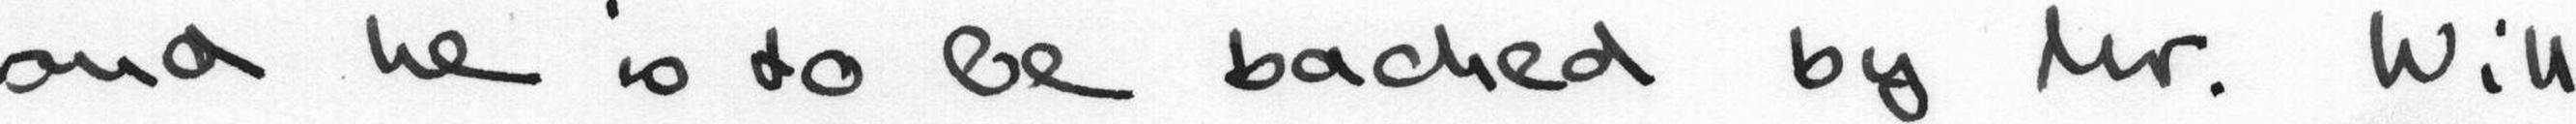

Sample 2 Text: nominating any more Labour life Peers


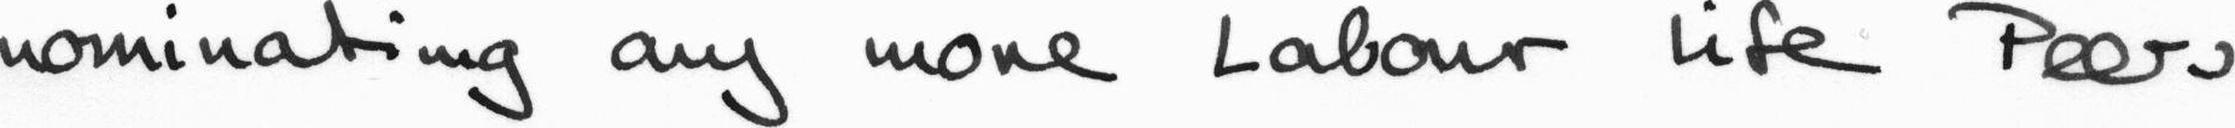

In [ ]:
for i in range(3):
    sample = dataset_iam['train'][i]
    print("Sample", i, "Text:", sample['text'])
    display(sample['image'])

Visualizing samples, we see entire lines of text that are much harder to recognize.


## Preprocessing and encoding
Converting text to sequences, processing images to a fixed height, and preparing for ctc.


In [ ]:
# clean the label so it only has characters a-z and
# so it is lowercase for more focused model

def clean_label(text):
  text_ = text['text']
  text_ = str(text_).lower()
  text_ = re.sub(r'[^a-z ]', '', text_)
  text['text'] = text_
  return text


In [ ]:
chars = ['<blank>'] + list(ascii_lowercase + digits + punctuation + ' ')
ctoi = {c: i for i, c in enumerate(chars)}

In [ ]:
img_height = 64
max_label_len = 100
batch_size = 256//2
val_perc = 0.2 # percentage for validaion set
max_img_width=img_height*4

# gpt  used 96 layers
trans_count = 3 # can only use one for for computational reasons

# in comparison, gpt3 used 96 attention heads
head_count = 4

# embed_dim same as from "attention is all you need". In comparison, gpt3 used
# 12 228 dimensions
emb_dim = 256 # or is 256 better for both embed dim and ff dim
ff_width = 4 * emb_dim
epochs = 10

drop_rate = 0.2

num_classes = len(chars) # only use characters from a-z

In [ ]:
def txt2seq(textvar):
    return [ctoi.get(ch, 0) for ch in textvar.lower()]

In [ ]:
def convertimg(img, img_height=64):
    img = img.convert('L')
    arr = np.array(img, dtype=np.float32)/255.0
    h, w = arr.shape
    ratio = img_height / h
    new_w = int(w * ratio)
    arr = np.array(
        Image.fromarray((arr*255).astype('uint8')).resize((new_w, img_height), Image.BICUBIC),
        dtype=np.float32
    )/255.0
    return arr

In [ ]:
def padseq(sequences):
    x = np.full((len(sequences), max_label_len), 0, dtype=np.int32)
    for idx, seqx in enumerate(sequences):
        length = min(len(seqx), max_label_len)
        x[idx, :length] = seqx[:length]
    return x

In [ ]:
def padimgs(images, value=0.0):
    batch_arr = np.full((len(images), img_height, max_img_width), value, dtype=np.float32)
    for i, im in enumerate(images):
        w = im.shape[1]

        width_to_use = min(w, max_img_width)
        batch_arr[i, :, :width_to_use] = im[:, :width_to_use]
    batch_arr = np.expand_dims(batch_arr, axis=-1)
    return batch_arr

In [ ]:
def datagen(ds, batch_size=batch_size, repeat=True):
    dlist = list(ds)
    while True:
        np.random.shuffle(dlist)
        for idx in range(0, len(dlist), batch_size):
            batchinfo = dlist[idx:idx+batch_size]
            if len(batchinfo) < batch_size and not repeat:
                break
            images = []
            sequences = []
            for ex in batchinfo:
                imp = convertimg(ex['image'], img_height=img_height)
                seqp = txt2seq(ex['text'])
                images.append(imp)
                sequences.append(seqp)

            X = padimgs(images)
            Y = padseq(sequences)


            # Computing input_length after the CNN, width is reduced by factor of 4 (two maxpools)
            # So the logit_length is original_width / 4
            # original_width = X.shape[2]
            # Each time-step isone position in the width  after CNN.
            logit_length = np.full((batch_size,), fill_value=X.shape[2]//4, dtype=np.int32)

            # label_length is the actual length of each label
            label_length = np.array([min(len(s), max_label_len) for s in sequences], dtype=np.int32)

            yield tf.convert_to_tensor(X), tf.convert_to_tensor(Y)

## Transformer encoder
Using positional embeddings and multi-head attention. This helps the model learn relationships in sequences.



Normally I would use the kerasnlp library for the positional embeddings, because that has classes that closely match the original Transformer architecture. Built-in layers like SinePositionEncoding and PositionEmbedding  are easy to plug in. But when I tried to install keras and then run my model, I kept getting errors. I spent a whole day trying to fix the issue, and it seemed like it was some compability issues with keras and tf. In the end, I had to uninstall Keras and make my own positional embedding layer. This ended up being simpler and more reliable. My class is still heavily inspired by "Attention is all you need"

In [ ]:
# This is heavily inspired by "Attention is all you need"

class Posemb(layers.Layer):
    def __init__(self, max_length=200): # i do not expect any sentences to be bigger
        super().__init__()
        self.embed_dim = emb_dim
        self.max_length = max_length

    def call(self, x):
        seq_len = tf.shape(x)[1]
        d_model = tf.cast(self.embed_dim, tf.float32)
        positions = tf.cast(tf.range(seq_len), tf.float32)[:, tf.newaxis]
        dims = tf.cast(tf.range(self.embed_dim), tf.float32)[tf.newaxis, :]

        angle_rates = 1.0 / tf.pow(10000.0, (2*(tf.floor(dims/2))) / d_model)
        angle_rads = positions * angle_rates

        eveninds = tf.range(0, self.embed_dim, 2)
        oddinds = tf.range(1, self.embed_dim, 2)

        evenrads = tf.gather(angle_rads, eveninds, axis=1)
        oddrads = tf.gather(angle_rads, oddinds, axis=1)

        evenrads = tf.sin(evenrads)
        oddrads = tf.cos(oddrads)

        even_expanded = tf.reshape(evenrads, [seq_len, -1, 1])
        odd_expanded = tf.reshape(oddrads, [seq_len, self.embed_dim//2, 1])
        interleaved = tf.reshape(
            tf.stack([even_expanded, odd_expanded], axis=-1),
            [seq_len, self.embed_dim]
        )

        pos_encoding = tf.expand_dims(interleaved, axis=0)
        return x + pos_encoding[:, :seq_len, :]

In [ ]:
# transfomer encoder

def transenc(x):
    attn_output = layers.MultiHeadAttention(num_heads=head_count, key_dim=emb_dim//head_count)(x, x)
    attn_output = layers.Dropout(drop_rate)(attn_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)

    ff_output = layers.Dense(ff_width, activation='relu')(x)
    ff_output = layers.Dense(emb_dim)(ff_output)
    ff_output = layers.Dropout(drop_rate)(ff_output)
    x = layers.LayerNormalization(epsilon=1e-6)(x + ff_output)
    return x

## Building the cnn+transformer model
First cnn extracts features, then we reshape to a sequence, then transformer encoder. Finally, we output logits and use ctc loss.


In [ ]:
def buildmodel(img_height=64, num_classes=num_classes, num_tlayer=trans_count):
    image_input = layers.Input(name='image', shape=(img_height, None, 1), dtype='float32')

    # CNN
    x = layers.Conv2D(16, (3,3), padding='same', activation='relu')(image_input)
    x = layers.MaxPooling2D((2,2))(x)
    x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
    x = layers.MaxPooling2D((2,2))(x)

    x = layers.Permute((2,1,3))(x)
    x = layers.Reshape((-1, 32*16))(x)

    x = layers.Dense(emb_dim)(x)

    # Transformer:
    x = Posemb(max_length=512)(x)
    for _ in range(num_tlayer):
        x = transenc(x)
    x = layers.Dense(num_classes)(x)  # No activation here!

    model = keras.Model(inputs=image_input, outputs=x)
    return model


In [ ]:
model = buildmodel()


In [ ]:
loss_fn = tf.keras.losses.CTC(reduction='sum_over_batch_size')



In [ ]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)        │ (None, 64, None, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 64, None, 16)   │            160 │ image[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 32, None, 16)   │              0 │ conv2d[0][0]           │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 32, None, 32)   │          4,640 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 16, None, 32)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ permute (Permute)         │ (None, None, 16, 32)   │              0 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, None, 512)      │              0 │ permute[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 256)      │        131,328 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ posemb (Posemb)           │ (None, None, 256)      │              0 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multi_head_attention      │ (None, None, 256)      │        263,168 │ posemb[0][0],          │
│ (MultiHeadAttention)      │                        │                │ posemb[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, None, 256)      │              0 │ multi_head_attention[… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, None, 256)      │              0 │ posemb[0][0],          │
│                           │                        │                │ dropout_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ layer_normalization       │ (None, None, 256)      │            512 │ add[0][0]              │
│ (LayerNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 1024)     │        263,168 │ layer_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, None, 256)      │        262,400 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_2 (Dropout)       │ (None, None, 256)      │              0 │ dense_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_1 (Add)               │ (None, None, 256)      │              0 │ layer_normalization[0… │
│                      

 Total params: 2,523,398 (9.63 MB)

 Trainable params: 2,523,398 (9.63 MB)

 Non-trainable params: 0 (0.00 B)

## Training


In [ ]:
train_data = dataset_iam['train']
val_data = dataset_iam['validation']
test_data = dataset_iam['test']

In [ ]:
train_data = train_data.map(clean_label, num_proc=3)
val_data = val_data.map(clean_label, num_proc=3)
test_data = test_data.map(clean_label, num_proc=3)

In [ ]:
train_gen = datagen(train_data, batch_size=batch_size, repeat=True)
val_gen = datagen(val_data, batch_size=batch_size, repeat=True)
test_gen = datagen(test_data, batch_size=batch_size, repeat=True)

In [ ]:
# confirming I have the correct dims
# and checking a few labels
for m in range(3):
  x,y= next(train_gen)

  print("x shape:", x.shape)
  print("y shape:", y.shape)
  label_indices = y[0].numpy()  # get label
  label = "".join([chars[i] for i in label_indices if i != -1])  # convert to char
  print("Label:", label)


x shape: (128, 64, 256, 1)
y shape: (128, 100)
Label: in fact  the brainchildren of inventive men <blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank>
x shape: (128, 64, 256, 1)
y shape: (128, 100)
Label: for many years my union had to present its views<blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank><blank>
x shape: (128, 64, 256, 1)
y shape: (128, 

Yep, looks good. Ready to train then.

In [ ]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-4), loss=loss_fn)

In [ ]:
# dropout likely makes train loss lower than val loss
history = model.fit(
    train_gen,
    steps_per_epoch=500, # since generator is repeating
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=50
)

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 246s 406ms/step - loss: 144.1180 - val_loss: 125.6293
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 158s 317ms/step - loss: 135.2447 - val_loss: 124.7564
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - loss: 133.6472 - val_loss: 123.3366
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 151s 303ms/step - loss: 130.6248 - val_loss: 121.8959
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - loss: 130.0458 - val_loss: 121.2698
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 283ms/step - loss: 129.3781 - val_loss: 120.8344
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 293ms/step - loss: 128.6841 - val_loss: 120.1424
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 147s 294ms/step - loss: 127.6371 - val_loss: 119.5816
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 293ms/step - loss: 126.4247 - val_loss: 119.6066
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 292ms/step - loss: 125.7134 - val_loss: 119.8687


We can see it takes around one minute per epoch, but the loss is high and is reducing slowly. I have tried many times with a lot of different parameters, and this is the best I could do. The loss does not go down much further, and with this loss, the model is not even useful.

I also did a few runs with higher steps_per_epoch, and reduced this as the model started to converge

The number of sentences the model sees per epoch is: steps_per_epoch * batch_size.
This is equal to 100 * 256, which is 25600.
We have around 88 000 in train, so it does not see the full dataset per epoch, but througout the 10 epochs it sees it at least twice.

## Decoding
We do greedy decoding of ctc. This is just a basic method to get the most likely next character, but it shows what the model thinks is the most likely though


In [ ]:
itoc = {v:k for k,v in ctoi.items()}

def decodegreedy(logits):
    pred_indices = np.argmax(logits, axis=-1)
    decoded_texts = []
    for seq in pred_indices:
        prev_char = None
        decoded = []
        for c in seq:
            if c != 0 and c != prev_char:
                decoded.append(itoc[c])
            prev_char = c
        decoded_texts.append("".join(decoded))
    return decoded_texts



In [ ]:
testdata = dataset_iam['test'].select(range(5))
testlist = list(testdata)

imagestest = []
labelstest = []
for ex in testlist:
    imp = convertimg(ex['image'], img_height=img_height)
    labelstest.append(ex['text'])
    imagestest.append(imp)

x_test = padimgs(imagestest) # padding them
logits_test = model.predict(x_test) # prdicing
predtest = decodegreedy(logits_test)


for i, (gt, pred) in enumerate(zip(labelstest, predtest)):
    print(f"True: {gt}")
    print(f"Pred:  {pred}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
True: assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .
Pred:  ceen heeeeee en

True: I don't think he will storm the charts with this one , but it 's a good start .
Pred:  ither hen e e e e e ee

True: CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .
Pred:  ch heenean er eee

True: Become a success with a disc and hey presto ! You 're a star ... . Rolly sings with
Pred:  fee ae e ehen eee

True: Tolch , as he is known in Tin Pan Alley , likes songs with a month in the title . He wrote
Pred:  th e i e e e ine



In [ ]:
# let us see if it gets any better if we train a little longer
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=50
)

# it is clearly overfitting now
# it also seems to be steadily getting worse as it overfits
# since we know see the val loss steadily incresing

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 319ms/step - loss: 123.9106 - val_loss: 120.5770
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 159s 319ms/step - loss: 122.6858 - val_loss: 120.7895
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 314ms/step - loss: 120.9866 - val_loss: 121.2139
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 154s 308ms/step - loss: 119.6719 - val_loss: 121.6219
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 150s 300ms/step - loss: 118.5654 - val_loss: 121.5145
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 141s 282ms/step - loss: 116.6873 - val_loss: 122.4268
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - loss: 115.4049 - val_loss: 124.6313
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 289ms/step - loss: 113.6934 - val_loss: 125.0640
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 145s 291ms/step - loss: 112.2900 - val_loss: 125.7443
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 146s 292ms/step - loss: 111.2920 - val_loss: 126.6646


In [ ]:
# we should see worse prediction due to higher val loss,
# but preds were pretty bad, so will be hard to notuce difference

testdata = dataset_iam['test'].select(range(5))
testlist = list(testdata)

imagestest = []
labelstest = []
for ex in testlist:
    imp = convertimg(ex['image'], img_height=img_height)
    labelstest.append(ex['text'])
    imagestest.append(imp)

x_test = padimgs(imagestest) # padding them
logits_test = model.predict(x_test) # prdicing
predtest = decodegreedy(logits_test)


for i, (gt, pred) in enumerate(zip(labelstest, predtest)):
    print(f"True: {gt}")
    print(f"Pred:  {pred}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
True: assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .
Pred:  antes thene din n  ne en een tha 

True: I don't think he will storm the charts with this one , but it 's a good start .
Pred:  ih thir h o this thit th he h e en

True: CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .
Pred:  che c hin mas ca  ane hi ant enwar 

True: Become a success with a disc and hey presto ! You 're a star ... . Rolly sings with
Pred:  feaene can has tha e hen an he  an

True: Tolch , as he is known in Tin Pan Alley , likes songs with a month in the title . He wrote
Pred:  teit es s s ho eo es e h e inhe ew en



In [ ]:
# let us see if it gets any better if we train a little longer
# at this stage, overfitting should make the words look better
# even if they are not correct for val set
history = model.fit(
    train_gen,
    steps_per_epoch=500,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=50
)


Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - loss: 109.8043 - val_loss: 129.7214
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 156s 313ms/step - loss: 107.9558 - val_loss: 129.7176
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 155s 310ms/step - loss: 106.8544 - val_loss: 128.7641
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 153s 306ms/step - loss: 104.9901 - val_loss: 130.2872
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 149s 300ms/step - loss: 103.6865 - val_loss: 132.2886
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - loss: 101.9623 - val_loss: 135.4619
Epoch 7/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 140s 280ms/step - loss: 100.5521 - val_loss: 135.2561
Epoch 8/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 288ms/step - loss: 98.7440 - val_loss: 136.9808
Epoch 9/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 144s 288ms/step - loss: 97.0823 - val_loss: 139.6943
Epoch 10/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 143s 287ms/step - loss: 95.9441 - val_loss: 140.9481


In [ ]:


testdata = dataset_iam['test'].select(range(5))
testlist = list(testdata)

imagestest = []
labelstest = []
for ex in testlist:
    imp = convertimg(ex['image'], img_height=img_height)
    labelstest.append(ex['text'])
    imagestest.append(imp)

x_test = padimgs(imagestest) # padding them
logits_test = model.predict(x_test) # prdicing
predtest = decodegreedy(logits_test)


for i, (gt, pred) in enumerate(zip(labelstest, predtest)):
    print(f"True: {gt}")
    print(f"Pred:  {pred}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
True: assuredness " Bella Bella Marie " ( Parlophone ) , a lively song that changes tempo mid-way .
Pred:  anraes theneatinp  n s nes esene se t sesea a 

True: I don't think he will storm the charts with this one , but it 's a good start .
Pred:  l dth thet he ewo therhetheteh th in

True: CHRIS CHARLES , 39 , who lives in Stockton-on-Tees , is an accountant .
Pred:  che cr hahastates as heesamh whar 

True: Become a success with a disc and hey presto ! You 're a star ... . Rolly sings with
Pred:  reare a end datd tha e hene o e he s tas

True: Tolch , as he is known in Tin Pan Alley , likes songs with a month in the title . He wrote
Pred:  teit osh w s lotontfs e d ainhini t in a t iew o



In [ ]:
# I really does get better despite overfitting
# reyinf with more steps now
history = model.fit(
    train_gen,
    steps_per_epoch=1000,
    epochs=epochs,
    validation_data=val_gen,
    validation_steps=100
)


Epoch 1/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 313s 314ms/step - loss: 93.0656 - val_loss: 145.9954
Epoch 2/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 312s 312ms/step - loss: 89.9116 - val_loss: 148.7106
Epoch 3/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 312s 312ms/step - loss: 86.9817 - val_loss: 152.7059
Epoch 4/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 310s 310ms/step - loss: 84.3401 - val_loss: 154.3917
Epoch 5/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 305s 305ms/step - loss: 81.7563 - val_loss: 159.1785
Epoch 6/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 297s 297ms/step - loss: 79.0618 - val_loss: 162.3820
Epoch 7/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 280s 280ms/step - loss: 76.8307 - val_loss: 164.8784
Epoch 8/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 278s 278ms/step - loss: 74.4157 - val_loss: 169.1345
Epoch 9/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 287s 287ms/step - loss: 72.3766 - val_loss: 171.6760
Epoch 10/10
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 288s 288ms/step - loss: 70.4417 - val_loss: 176.2576


In [ ]:
# I'll use the clean one for easier comparison
testlist = list(test_data.select(range(5)))

In [ ]:
imagestest = []
labelstest = []
for ex in testlist:
    imp = convertimg(ex['image'], img_height=img_height)
    labelstest.append(ex['text'])
    imagestest.append(imp)

x_test = padimgs(imagestest) # padding them
logits_test = model.predict(x_test) # prdicing
predtest = decodegreedy(logits_test)


for i, (gt, pred) in enumerate(zip(labelstest, predtest)):
    print(f"True: {gt}")
    print(f"Pred:  {pred}")
    print()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
True: assuredness  bella bella marie   parlophone   a lively song that changes tempo midway 
Pred:  anratlrs themeaiki peai ninsaefonekmese ot shs a ney

True: i dont think he will storm the charts with this one  but it s a good start 
Pred:  i tih thent he nodt ese tharewetehave nra empar

True: chris charles    who lives in stocktonontees  is an accountant 
Pred:  cri mrlrun hest esin mesasamamttial 

True: become a success with a disc and hey presto  you re a star   rolly sings with
Pred:  reae aocecd iatnhae edtot o o oes thes

True: tolch  as he is known in tin pan alley  likes songs with a month in the title  he wrote
Pred:  tert  ow wis atonata sr eiw dance a w na herie ws



As we can see, output is just jibberish, but it does seem to improve. The loss is really high, so the model has kjust not learned anything useful ye. We would have to make the model more complex and get more data to imrpove val loss, but with this simple model, letting it overfit at least makes the output look a little bit more like text. But high val loss means that we are still far from the correct sentences.

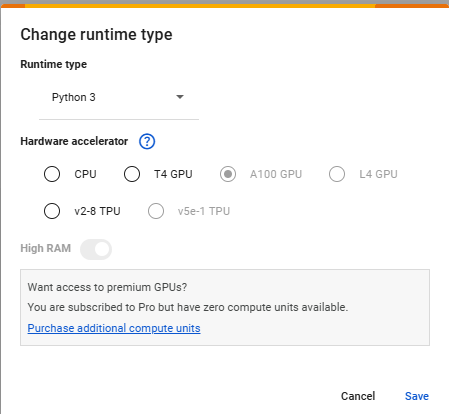

After spending a lot of money on GPUs to try to tune this model, I think I have to leave it with the disappointing result.

# USing huge pretrained model (trocr)

I will now use a large pretrained model: trocr. This model might start at a lower loss, but it is still not completely perfect. This just shows how hard it is to create a model that can transcribe handwriting, and it requires a lot of data and computational power to do so

In [ ]:

droprate = 0.2

## Loading the pretrained trocr model and processor

I load the processor and model from huggingface. The TrOCRProcessor handles image and text preprocessing, and the TFVisionEncoderDecoderModel is the pretrained model.

In [ ]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [ ]:
modetrocr = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.1"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

N: Batch size
C: Number of channels 3 for RGB
H: Height
W: Width

In [ ]:
def prep_trocr(ex):
    # converting image to RGB
    img = ex["image"].convert("RGB")
    # using processor to get pixel_values
    pixel_vals = processor(img, return_tensors="np").pixel_values[0] # returns NCHW
    # converting text to lowercase
    txt = ex["text"].lower()
    lbls = processor.tokenizer(txt, return_tensors="np").input_ids[0]
    return {"pixel_values": pixel_vals, "labels": lbls}


In [ ]:
#train_map = train_data.map(prep_trocr, batched=False)
#val_map = val_data.map(prep_trocr, batched=False)
test_map = test_data.map(prep_trocr, batched=False)

Map:   0%|          | 0/6482 [00:00<?, ? examples/s]

Map:   0%|          | 0/976 [00:00<?, ? examples/s]

Map:   0%|          | 0/2915 [00:00<?, ? examples/s]

In [ ]:

# Remove columns not needed (to avoid confusion during dataloader creation)
#train_map.set_format(type="torch", columns=["pixel_values", "labels"])
#val_map.set_format(type="torch", columns=["pixel_values", "labels"])
test_map.set_format(type="torch", columns=["pixel_values", "labels"])

In [ ]:
# mode model to gpu
device = "cuda"

In [ ]:
modetrocr.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linea

In [ ]:
modetrocr.eval()
for i in range(0, 5):
    ex = test_map[i]
    pixel_values = ex["pixel_values"].unsqueeze(0).to(device)

    # predictions
    predicted_ids = modetrocr.generate(pixel_values)
    pred_text = processor.tokenizer.decode(predicted_ids[0], skip_special_tokens=True)
    print("True", test_data[i]["text"])
    print("Pred:  ", pred_text)
    print()

True assuredness  bella bella marie   parlophone   a lively song that changes tempo midway 
Pred:   assuredness " Bella Bella Marie " ( Bishopsome ) a lively song that changes tempo midway

True i dont think he will storm the charts with this one  but it s a good start 
Pred:   I don't think he will storm the charts with this one , but it's a good start .

True chris charles    who lives in stocktonontees  is an accountant 
Pred:   CHRIS CHARLES , 33 , who lives in Stockton - on - Tee's , is an

True become a success with a disc and hey presto  you re a star   rolly sings with
Pred:   Become a success with a disc and they presto ! You're a star ... Rolly sings

True tolch  as he is known in tin pan alley  likes songs with a month in the title  he wrote
Pred:   Folch , as he is known in Tin Pan Alley , lives , with a month in the



As we can see, there is a few mistakes. We could potentially make the model even better with finetuning, but since it is a huge model, we won't be able to finetune down to no mistakes. The model is already really good.

## Summary

We started with single letters using a cnn and got good results. For entire lines, even with advanced models (cnn+transformer or trocr), achieving a low loss and perfect transcription is tough and needs much more data and training.

The key idea: handwriting recognition at sentence level is complex, ctc loss helps but is expensive, and even pretrained models could need fine-tuning. Without huge computational resources and time, I can only show a demonstration.
